In [1]:
import pandas as pd

news_original = pd.read_csv('./news.csv', index_col=0)
news_original.head()

,authors,title,publish_date,description,text,url
0,[],'More vital now:' Gay-straight alliances go vi...,2020-05-03 1:30,Lily Overacker and Laurell Pallot start each g...,Lily Overacker and Laurell Pallot start each g...,https://www.cbc.ca/news/canada/calgary/gay-str...
1,[],Scientists aim to 'see' invisible transmission...,2020-05-02 8:00,Some researchers aim to learn more about how t...,"This is an excerpt from Second Opinion, a week...",https://www.cbc.ca/news/technology/droplet-tra...
2,['The Canadian Press'],Coronavirus: What's happening in Canada and ar...,2020-05-02 11:28,Canada's chief public health officer struck an...,The latest: The lives behind the numbers: Wha...,https://www.cbc.ca/news/canada/coronavirus-cov...
3,[],"B.C. announces 26 new coronavirus cases, new c...",2020-05-02 18:45,B.C. provincial health officer Dr. Bonnie Henr...,B.C. provincial health officer Dr. Bonnie Henr...,https://www.cbc.ca/news/canada/british-columbi...
4,[],"B.C. announces 26 new coronavirus cases, new c...",2020-05-02 18:45,B.C. provincial health officer Dr. Bonnie Henr...,B.C. provincial health officer Dr. Bonnie Henr...,https://www.cbc.ca/news/canada/british-columbi...


In [2]:
news = news_original.copy()

contents = []
for index, row in news.iterrows():
  content = ''
  if isinstance(row['title'], str):
    content += row['title']
  if isinstance(row['description'], str):
    content += row['description']
  if isinstance(row['text'], str):
    content += row['text']
  contents.append(content)

news['content'] = contents[:]

del news['title'], news['description'], news['text']
news.head()

,authors,publish_date,url,content
0,[],2020-05-03 1:30,https://www.cbc.ca/news/canada/calgary/gay-str...,'More vital now:' Gay-straight alliances go vi...
1,[],2020-05-02 8:00,https://www.cbc.ca/news/technology/droplet-tra...,Scientists aim to 'see' invisible transmission...
2,['The Canadian Press'],2020-05-02 11:28,https://www.cbc.ca/news/canada/coronavirus-cov...,Coronavirus: What's happening in Canada and ar...
3,[],2020-05-02 18:45,https://www.cbc.ca/news/canada/british-columbi...,"B.C. announces 26 new coronavirus cases, new c..."
4,[],2020-05-02 18:45,https://www.cbc.ca/news/canada/british-columbi...,"B.C. announces 26 new coronavirus cases, new c..."


In [3]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from nltk import download
download('wordnet')
download('averaged_perceptron_tagger')

from nltk import WordNetLemmatizer, pos_tag
from nltk.corpus import wordnet

def get_pos(token):  # get part of speech
  tag = pos_tag([token])[0][1][0].upper()
  tag_dict = {
    "J": wordnet.ADJ,
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "R": wordnet.ADV
  }
  return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package wordnet to /home/andrew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/andrew/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
wnl = WordNetLemmatizer()

preprocessed_content = []

for index, row in news.iterrows():
  content = []
  for token in simple_preprocess(row['content']):
    if not (token in STOPWORDS):
      content.append(wnl.lemmatize(token, pos=get_pos(token)))
  preprocessed_content.append(' '.join(content))

news['preprocessed_content'] = preprocessed_content[:]
news

,authors,publish_date,url,content,preprocessed_content
0,[],2020-05-03 1:30,https://www.cbc.ca/news/canada/calgary/gay-str...,'More vital now:' Gay-straight alliances go vi...,vital gay straight alliance virtual coronaviru...
1,[],2020-05-02 8:00,https://www.cbc.ca/news/technology/droplet-tra...,Scientists aim to 'see' invisible transmission...,scientist aim invisible transmission coronavir...
2,['The Canadian Press'],2020-05-02 11:28,https://www.cbc.ca/news/canada/coronavirus-cov...,Coronavirus: What's happening in Canada and ar...,coronavirus happen canada world canada chief p...
3,[],2020-05-02 18:45,https://www.cbc.ca/news/canada/british-columbi...,"B.C. announces 26 new coronavirus cases, new c...",announces new coronavirus case new community o...
4,[],2020-05-02 18:45,https://www.cbc.ca/news/canada/british-columbi...,"B.C. announces 26 new coronavirus cases, new c...",announces new coronavirus case new community o...
...,...,...,...,...,...
6782,['Cbc News'],2020-04-06 10:49,https://www.cbc.ca/news/canada/windsor/fishing...,Fishing industry in Windsor-Essex shut down du...,fishing industry windsor essex shut peak seaso...
6783,['Cbc News'],2020-03-18 17:08,https://www.cbc.ca/news/canada/ottawa/tunneys-...,Health Canada worker tests positive for COVID-...,health canada worker test positive covid healt...
6784,['Cbc News'],2020-04-19 11:30,https://www.cbc.ca/news/canada/newfoundland-la...,Taxis adapting to COVID-19 with plastic shield...,taxi adapt covid plastic shield passenger limi...
6785,[],2020-03-31 12:55,https://www.cbc.ca/news/canada/edmonton/shawn-...,'An amazing man': Young father identified as n...,amaze man young father identify northern alber...


In [5]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bigram_model = Phrases([ content.split() for content in preprocessed_content ])

In [6]:
enriched_content = []

for index, row in news.iterrows():
  enriched_content.append(bigram_model[row['preprocessed_content'].split()])

news['preprocessed_content'] = [ ' '.join(content) for content in enriched_content ]
news.head()

,authors,publish_date,url,content,preprocessed_content
0,[],2020-05-03 1:30,https://www.cbc.ca/news/canada/calgary/gay-str...,'More vital now:' Gay-straight alliances go vi...,vital gay_straight alliance virtual coronaviru...
1,[],2020-05-02 8:00,https://www.cbc.ca/news/technology/droplet-tra...,Scientists aim to 'see' invisible transmission...,scientist aim invisible transmission coronavir...
2,['The Canadian Press'],2020-05-02 11:28,https://www.cbc.ca/news/canada/coronavirus-cov...,Coronavirus: What's happening in Canada and ar...,coronavirus happen canada world canada chief_p...
3,[],2020-05-02 18:45,https://www.cbc.ca/news/canada/british-columbi...,"B.C. announces 26 new coronavirus cases, new c...",announces_new coronavirus case new community o...
4,[],2020-05-02 18:45,https://www.cbc.ca/news/canada/british-columbi...,"B.C. announces 26 new coronavirus cases, new c...",announces_new coronavirus case new community o...


In [39]:
from gensim.corpora import Dictionary

dictionary = Dictionary(enriched_content)
dictionary.filter_extremes(no_below=20, no_above=0.4, keep_n=10000)
#bag of words
bow = [ dictionary.doc2bow(content) for content in enriched_content ]

In [40]:
from gensim.models  import LdaMulticore

model = LdaMulticore(
    bow,
    id2word = dictionary,
    num_topics = 25,
    chunksize = 1000,
    passes = 200,
    alpha=50/25,
    workers = 6,
    random_state = 10
)

In [41]:
for topic, words in model.print_topics(-1):
    print('Topic {}: {}'.format(topic, words))

Topic 0: 0.103*"test" + 0.022*"symptom" + 0.018*"test_positive" + 0.017*"confirm" + 0.015*"contact" + 0.014*"person" + 0.014*"positive" + 0.013*"new_brunswick" + 0.012*"result" + 0.011*"centre"
Topic 1: 0.032*"quebec" + 0.025*"montreal" + 0.022*"region" + 0.018*"hamilton" + 0.015*"city" + 0.011*"service" + 0.011*"windsor" + 0.009*"march" + 0.009*"local" + 0.008*"legault"
Topic 2: 0.021*"family" + 0.013*"life" + 0.010*"year" + 0.008*"get" + 0.008*"way" + 0.007*"event" + 0.007*"love" + 0.007*"feel" + 0.006*"want" + 0.006*"friend"
Topic 3: 0.038*"business" + 0.021*"href_http" + 0.019*"customer" + 0.019*"food" + 0.017*"store" + 0.013*"twitter_com" + 0.013*"restaurant" + 0.009*"owner" + 0.009*"twsrc_etfw" + 0.009*"local"
Topic 4: 0.021*"order" + 0.018*"emergency" + 0.013*"state_emergency" + 0.012*"territory" + 0.011*"kandola" + 0.010*"health_officer" + 0.010*"want" + 0.010*"march" + 0.009*"public" + 0.008*"yellowknife"
Topic 5: 0.075*"worker" + 0.037*"company" + 0.034*"employee" + 0.015*"pl

In [42]:
topics_count = [ [topic, 0] for topic in range(25) ]

for content in bow:
    topics = model.get_document_topics(content, minimum_probability=0.1)
    for topic, weight in topics:
        topics_count[topic][1] += 1

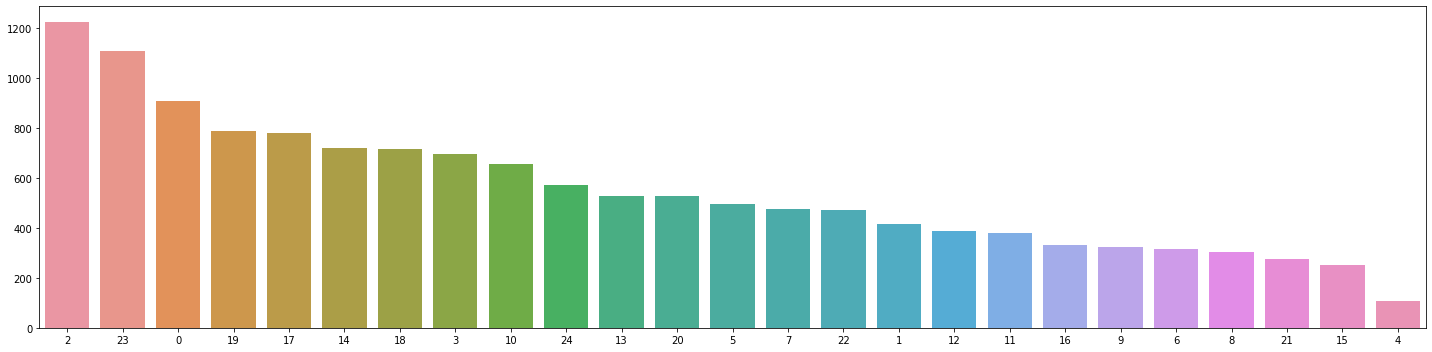

In [43]:

import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter

topics_count.sort(key=itemgetter(1), reverse=True)

data = {
    'Topic': [ topic[0] for topic in topics_count ],
    'Number of news': [ topic[1] for topic in topics_count ]
}

plt.figure(figsize=(20,5))
ax = sns.barplot(x="Topic", y="Number of news", data=data, order=data['Topic'])
plt.tight_layout()
plt.show()

In [117]:
from wordcloud import WordCloud

def showWordCloud(topic, label):
    plt.figure(figsize=(10,5))
    wordcloud = WordCloud(background_color="white")
    plt.imshow(wordcloud.fit_words(dict(model.show_topic(topic, 10))))
    plt.axis("off")
    plt.title("{} ({})".format(label, topic), fontsize=28, pad=35)
    plt.show()

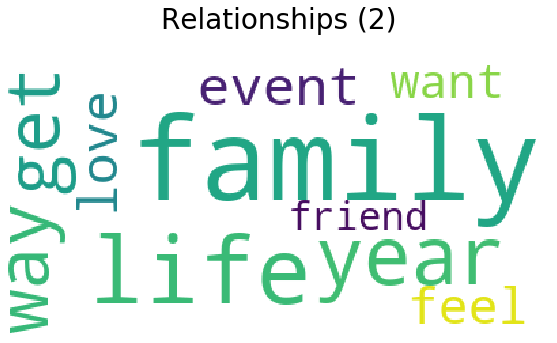

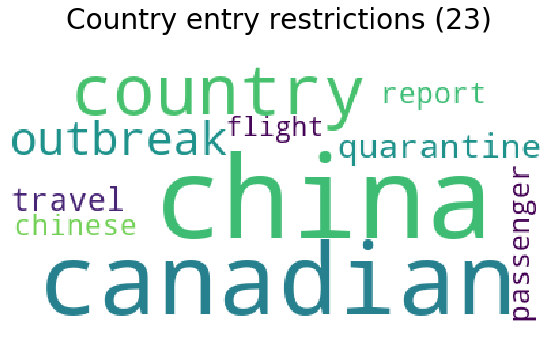

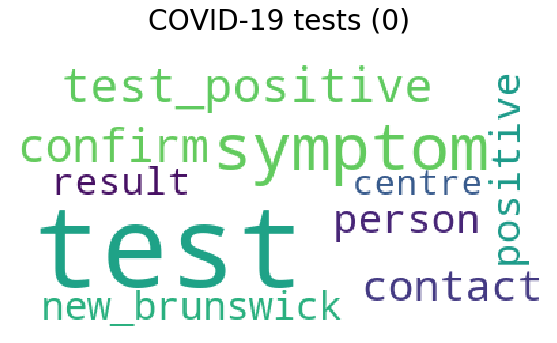

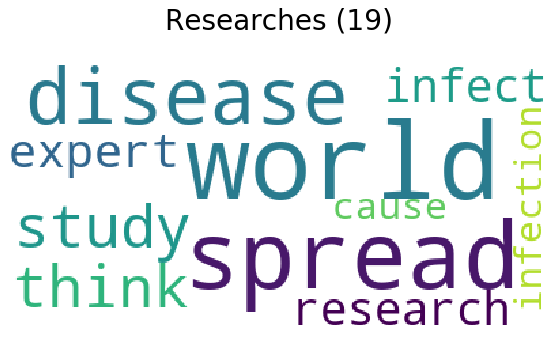

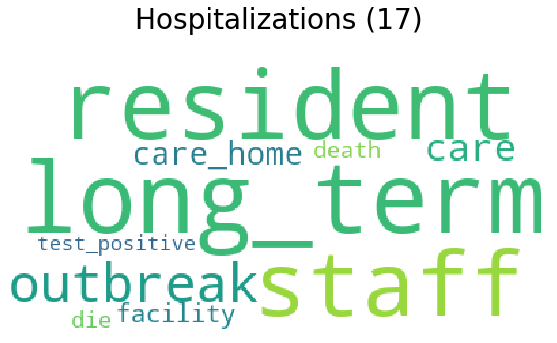

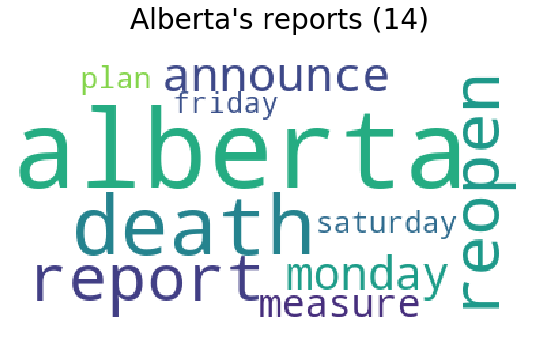

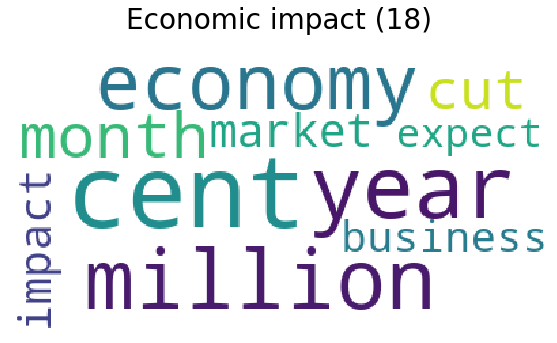

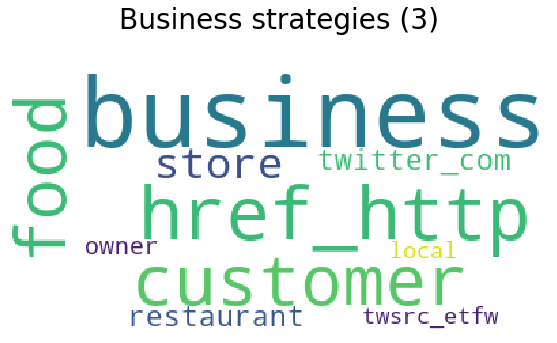

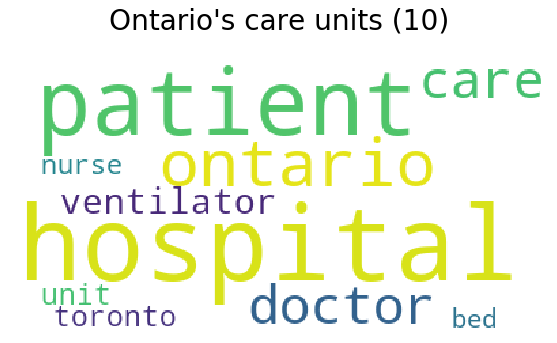

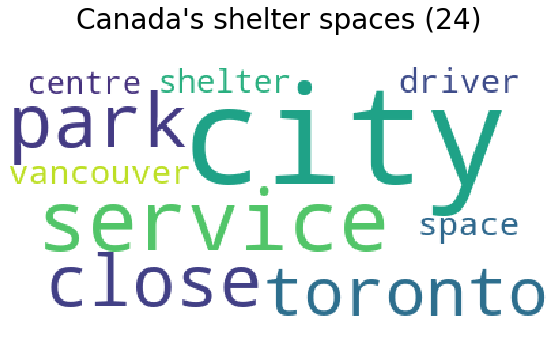

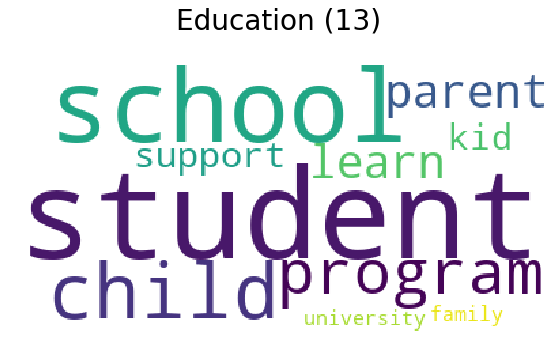

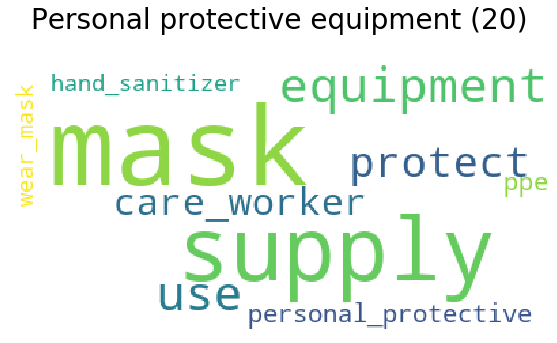

In [118]:
showWordCloud(2, "Relationships")
showWordCloud(23, "Country entry restrictions")
showWordCloud(0, "COVID-19 tests")
showWordCloud(19, "Researches")
showWordCloud(17, "Hospitalizations")
showWordCloud(14, "Alberta's reports")
showWordCloud(18, "Economic impact")
showWordCloud(3, "Business strategies")
showWordCloud(10, "Ontario's care units")
showWordCloud(24, "Canada's shelter spaces")
showWordCloud(13, "Education")
showWordCloud(20, "Personal protective equipment")